In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
from transformer_lens.hook_points import HookPoint
import numpy as np
import matplotlib.pyplot as plt

In [106]:
class MLP(nn.Module):
    def __init__(self, instances, in_dim, hidden_dim):
        super(MLP, self).__init__()
        self.w1 = nn.Parameter(torch.randn(instances, in_dim, hidden_dim) * 0.02)
        #self.w2 = nn.Parameter(torch.randn(in_dim, hidden_dim))
        self.b = nn.Parameter(torch.zeros(instances, in_dim))

        #self.hook = HookPoint()
    
    def forward(self, x):
        x = F.relu(einops.einsum(self.w1, x, "i f h, i b f -> i b h"))
        #x = self.hook(x)
        x = F.relu(einops.einsum(self.w1, x, "i f h, i b h -> i b f") + self.b.view(x.shape[0], 1, -1))
        return x

In [107]:
instances=1

n_features = 100
n_hidden = 40
model = MLP(10, n_features, n_hidden)
n_sparse = 50
f_sparse = 0.01
f_dense = 0.1

importances = [0.9 ** i for i in range(n_sparse)] + [0.9 ** i for i in range(n_features - n_sparse)]

In [108]:
# training
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=0.001)

# linear lr warmup then exp decay

warmup = 1000
gamma = 0.9999

def lr_lambda(epoch):
    if epoch < warmup:
        return epoch / warmup
    return gamma ** (epoch - warmup)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

batch_size = 100

importance = torch.tensor(importances)

print(importance)

losses = []

for epoch in range(10000):
    optimizer.zero_grad()
    input = torch.rand(instances, batch_size, n_features)

    
    #input[:, :n_sparse] = 0

    # first 50 features are sparse
    # randomly zero elements 1-f_sparse percent of the time
    input[:, :, :n_sparse] = input[:, :, :n_sparse] * (torch.rand(instances, batch_size, n_sparse) < f_sparse).float()

    # last 50 features are dense
    # randomly zero elements 1-f_dense percent of the time
    input[:, :, n_sparse:] = input[:, :, n_sparse:] * (torch.rand(instances, batch_size, n_features-n_sparse) < f_dense).float()

    target = input
    output = model(input)
    loss = (importance * (output - target) ** 2).mean(dim=-1).mean(dim=-1).sum()
    loss.backward()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print("epoch", epoch, "loss", loss.item())
    optimizer.step()
    scheduler.step()

tensor([1.0000, 0.9000, 0.8100, 0.7290, 0.6561, 0.5905, 0.5314, 0.4783, 0.4305,
        0.3874, 0.3487, 0.3138, 0.2824, 0.2542, 0.2288, 0.2059, 0.1853, 0.1668,
        0.1501, 0.1351, 0.1216, 0.1094, 0.0985, 0.0886, 0.0798, 0.0718, 0.0646,
        0.0581, 0.0523, 0.0471, 0.0424, 0.0382, 0.0343, 0.0309, 0.0278, 0.0250,
        0.0225, 0.0203, 0.0182, 0.0164, 0.0148, 0.0133, 0.0120, 0.0108, 0.0097,
        0.0087, 0.0079, 0.0071, 0.0064, 0.0057, 1.0000, 0.9000, 0.8100, 0.7290,
        0.6561, 0.5905, 0.5314, 0.4783, 0.4305, 0.3874, 0.3487, 0.3138, 0.2824,
        0.2542, 0.2288, 0.2059, 0.1853, 0.1668, 0.1501, 0.1351, 0.1216, 0.1094,
        0.0985, 0.0886, 0.0798, 0.0718, 0.0646, 0.0581, 0.0523, 0.0471, 0.0424,
        0.0382, 0.0343, 0.0309, 0.0278, 0.0250, 0.0225, 0.0203, 0.0182, 0.0164,
        0.0148, 0.0133, 0.0120, 0.0108, 0.0097, 0.0087, 0.0079, 0.0071, 0.0064,
        0.0057])
epoch 0 loss 0.15608204901218414
epoch 100 loss 0.1548985242843628
epoch 200 loss 0.0987858921289444
ep

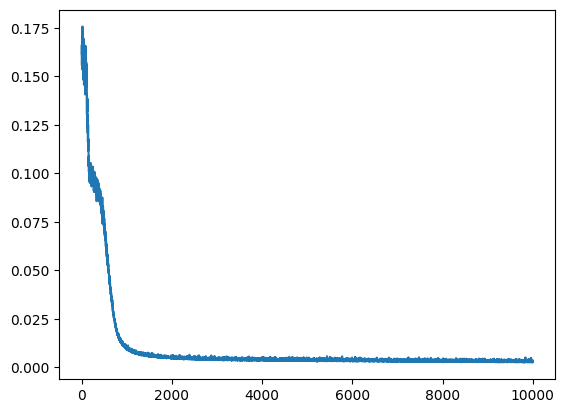

In [109]:
plt.plot(losses)
plt.show()

In [115]:
def visualize_weights_stacked(w_matrix, cols = None):
    # view the weights as a series of stacked boxes
    np_arr = w_matrix.detach().numpy()
    rows = [np_arr[:, x] for x in range(np_arr.shape[1])]
    col_sums = np.zeros(np_arr.shape[0])
    for i, row in enumerate(rows):
        if cols is not None:
            for n, col in cols:
                if i < n:
                    color = col
                    break
                else:
                    i -= n
        else:
            color = None

        plt.bar(range(np_arr.shape[0]), row ** 2, bottom=col_sums, linewidth=0.5, edgecolor="white", color=color)
        col_sums += row ** 2
    plt.show()

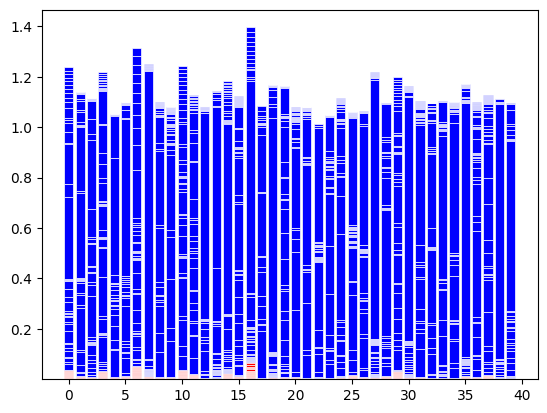

In [116]:
visualize_weights_stacked(model.w1[0].T, cols=[(n_sparse, "red"), (n_features-n_sparse, "blue")])
#visualize_weights_stacked(model.w2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


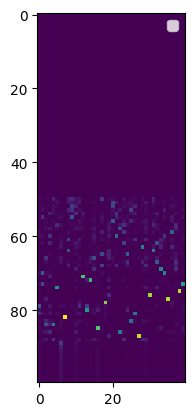

In [117]:
# draw the weights as a heatmap
for i in range(instances):
    plt.imshow(model.w1[i].detach().numpy() ** 2)
    plt.legend()
    plt.show()

#plt.imshow(model.w2.detach().numpy())
#plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


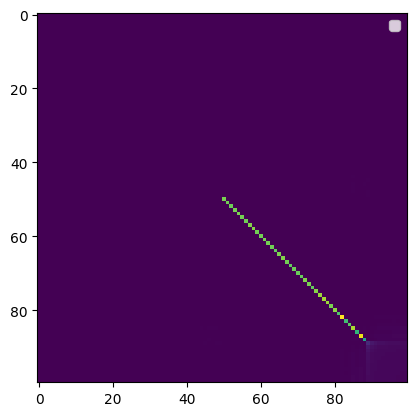

In [118]:
# plot w1.T @ w1

for i in range(instances):
    plt.imshow((model.w1[i] @ model.w1[i].T).detach().numpy())
    plt.legend()
    plt.show()